In [10]:
'''
Script for calculating zalandos coding challenge: calculate most likely position given three distributions.
The distributions are defined as follows:
The candidate is likely to be close to the river Spree. The probability at any point is given by a Gaussian function 
of its shortest distance to the river. The function peaks at zero and has 95% of its total integral within +/-2730m

A probability distribution centered around the Brandenburg Gate also informs us of the candidate's location. The 
distribution’s radial profile is log-normal with a mean of 4700m and a mode of 3877m in every direction.

A satellite offers further information: with 95% probability she is located within 2400 m distance of the satellite’s 
path (assuming a normal probability distribution)

A file with latitude longitude info of the points is given'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
#sns.set_palette("colorblind")
import shapely.geometry as geo
import itertools
%matplotlib inline

In [2]:
SW_lat = 52.464011 
SW_lon = 13.274099 
def calcPos(P_lat,P_lon):
    """Transform GPS coords into xy grid coords according to zalandos formula"""
    P_x = (P_lon - SW_lon) * np.cos(SW_lat * np.pi / 180) * 111.323
    P_y = (P_lat - SW_lat) * 111.323
    return P_x,P_y

In [5]:
from math import radians, cos, sin, asin, sqrt
def haversine(lat1,lon1,lat2,lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Micheal Dunns's function from stackoverflow
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

difference of Line - great circle length 0.029 km


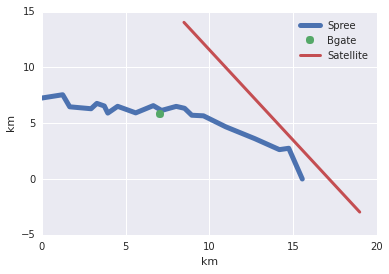

In [23]:
#x,y coordinates of bgate
bgate=geo.Point(calcPos(52.516288,13.377689))
#spree
spreePoints = [[52.529198,13.274099],[52.531835,13.29234],[52.522116,13.298541],[52.520569,13.317349],[52.524877,13.322434],[52.522788,13.329],\
[52.517056,13.332075],[52.522514,13.340743],[52.517239,13.356665],[52.523063,13.372158],[52.519198,13.379453],[52.522462,13.392328],\
[52.520921,13.399703],[52.515333,13.406054],[52.514863,13.416354],[52.506034,13.435923],[52.496473,13.461587],[52.487641,13.483216],\
               [52.488739,13.491456],[52.464011,13.503386]]
spree = geo.LineString(calcPos(*val) for val in spreePoints)
#and satellite: Line is a close approx. to great circle (see difference in length of both)
satPoints=[[52.590117,13.39915],[52.437385,13.553989]]
sat = geo.LineString(calcPos(*val) for val in satPoints)
print 'difference of Line - great circle length %.3f km' %(sat.length-haversine(*list(itertools.chain.from_iterable(satPoints))))

plt.plot(spree.xy[0],spree.xy[1],linewidth=5,label='Spree')
plt.plot(bgate.xy[0],bgate.xy[1],'o',markersize=8,label='Bgate')
plt.plot(sat.xy[0],sat.xy[1],linewidth=3,label='Satellite')
plt.xlabel('km')
plt.ylabel('km')
plt.legend()

to set up densities around bgate:
following wikis entry on lognormal
$$mean = e^{\mu + \frac{\sigma^2}{2}}$$
$$mode = e^{\mu - \sigma^2}$$
reforming them s.t. 
$$\sigma=\sqrt{\frac{2}{3}*ln(mean/mode)}$$
becoming the scale parameter and
$$\mu=\frac{2}{3}ln(mean) + \frac{1}{3}ln(mode)$$
becoming the location parameter

scale= 0.358, location = 1.483


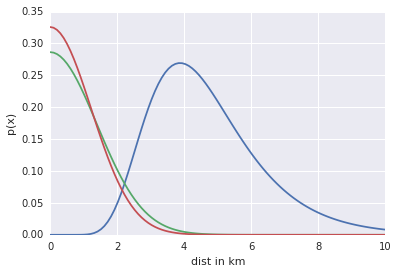

In [24]:
#Brandenbruger Gate dist
b_mean = 4.700
b_mode = 3.877
b_sigma = np.sqrt((2.0/3)* np.log(b_mean/b_mode))
b_mu = 2.0/3* np.log(b_mean)+ 1.0/3*np.log(b_mode)
print 'scale= %.3f, location = %.3f' %(b_sigma,b_mu)
#scipys lognormal implementation uses another parameter called shape: 
#If log(x) is normally distributed with mean mu and variance sigma**2, then x is log-normally distributed with shape parameter sigma and scale parameter exp(mu).
bgate_lognormal = scipy.stats.lognorm(s=b_sigma, scale=np.exp(b_mu))

#Spree dist
spree_normal = scipy.stats.norm(0,scale = 2.730/1.96) #1.96 is std converter for 95% confidence
#Satellite dist
sat_normal = scipy.stats.norm(0,scale = 2.400/1.96)


x = np.linspace(0,10,100)
plt.plot(x,bgate_lognormal.pdf(x))
#plt.plot(np.log(x),bgate_lognormal.pdf(x)) #sanity check: is normally distr with mean = 1.4 and std = 0.358
plt.plot(x,spree_normal.pdf(x))
plt.plot(x,sat_normal.pdf(x))
plt.xlabel('dist in km')
plt.ylabel('p(x)')

In [40]:
def comp_prob(origin=None,distribution=None):
    return lambda x,y: distribution.pdf(geo.Point(x, y).distance(origin))

def joint_prob(x,y):
    '''Joint probability of independent sources, as said on problem statement, is the product of individual probs'''
    return comp_prob(origin=bgate,distribution=bgate_lognormal)(x,y) * \
           comp_prob(origin=spree,distribution=spree_normal)(x,y) * \
           comp_prob(origin=sat,distribution=sat_normal)(x,y)

In [42]:
(minx, miny, maxx, maxy) = spree.bounds

gridsize = 300
x,y = np.linspace(8,18,gridsize),np.linspace(0,10,gridsize) #zooming in on most likely position while plotting reasonable area
X,Y = np.meshgrid(x,y)
g = np.vectorize(joint_prob) # shapely geometery objects won't take arrays...
Z = g(X,Y)

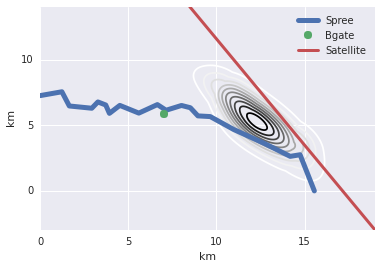

In [48]:
plt.contour(X, Y, Z,10)
plt.plot(spree.xy[0],spree.xy[1],linewidth=5,label='Spree')
plt.plot(bgate.xy[0],bgate.xy[1],'o',markersize=8,label='Bgate')
plt.plot(sat.xy[0],sat.xy[1],linewidth=3,label='Satellite')
plt.xlabel('km')
plt.ylabel('km')
plt.legend()

In [53]:
SW_lat = 52.464011 
SW_lon = 13.274099 
def reverseCalcPos(P_x,P_y):
    """Transform GPS coords into xy grid coords according to zalandos formula"""
    P_lon = P_x / (np.cos(SW_lat * np.pi / 180) * 111.323) + SW_lon
    P_lat = P_y / 111.323 + SW_lat
    return P_lat,P_lon

In [54]:
#dest_lat,dest_lon = 
print reverseCalcPos(np.ravel(X)[np.argmax(Z)],np.ravel(Y)[np.argmax(Z)])

(52.511479006938863, 13.455168030672404)


52.511479006938863 latitude, 13.455168030672404 longitude is Grünberger Str. 52, 10245 Berlin, which is a sudanese Fallafel shop called Nil. It's my favorite in Fhain and I've been there multilpe times : )